In [2]:
import pandas as pd


df = pd.read_csv('df_clean_main.csv')
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'OnlineBackup',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'MonthlyCharges', 'TotalCharges', 'numAdminTickets', 'numTechTickets',
       'Churn', 'ln_TotalCharges', 'gender_encoded', 'Partner_encoded',
       'PhoneService_encoded', 'StreamingMovies_encoded',
       'PaperlessBilling_encoded', 'Churn_encoded', 'OnlineSecurity_No',
       'OnlineSecurity_No internet service', 'OnlineSecurity_Yes',
       'calls_count', 'InternetService_DSL', 'InternetService_Fiber optic',
       'InternetService_No', 'DeviceProtection_No',
       'DeviceProtection_No internet service', 'DeviceProtection_Yes',
       'TechSupport_No', 'TechSupport_No internet service', 'TechSupport_Yes',
       'PaymentMethod_Bank transfer (automatic)',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed c

Для начала определим какие признаки могут быть использованы для логистической регрессии.

In [3]:
df.dtypes

customerID                                  object
gender                                      object
SeniorCitizen                                int64
Partner                                     object
Dependents                                  object
tenure                                       int64
PhoneService                                object
MultipleLines                               object
OnlineBackup                                object
StreamingTV                                 object
StreamingMovies                             object
Contract                                    object
PaperlessBilling                            object
MonthlyCharges                             float64
TotalCharges                               float64
numAdminTickets                              int64
numTechTickets                               int64
Churn                                       object
ln_TotalCharges                            float64
gender_encoded                 

Убираем не числовые и категориальные

In [4]:
df_cleaned = df.drop(['customerID', 'gender', 'Partner', 'Dependents',
       'PhoneService', 'MultipleLines', 'OnlineBackup', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'Churn', 'ln_TotalCharges',
       ], axis=1)

df_cleaned.corr(method='spearman', numeric_only=True)['Churn_encoded']

SeniorCitizen                              0.139826
tenure                                    -0.386146
MonthlyCharges                             0.135664
TotalCharges                              -0.277303
numAdminTickets                           -0.028311
numTechTickets                             0.408255
gender_encoded                            -0.008391
Partner_encoded                           -0.149827
PhoneService_encoded                       0.044143
StreamingMovies_encoded                   -0.035643
PaperlessBilling_encoded                   0.172677
Churn_encoded                              1.000000
OnlineSecurity_No                          0.320107
OnlineSecurity_No internet service        -0.176414
OnlineSecurity_Yes                        -0.215818
calls_count                                0.592399
InternetService_DSL                       -0.180823
InternetService_Fiber optic                0.291625
InternetService_No                        -0.176414
DeviceProtec


Подходящие признаки:
tenure                                    -0.386146
TotalCharges                              -0.277303
numTechTickets                             0.408255
OnlineSecurity_No                          0.320107
calls_count                                0.592399
InternetService_Fiber optic                0.291625
DeviceProtection_No                        0.223887
TechSupport_No                             0.314235
PaymentMethod_Electronic check             0.292554

In [5]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Убираем признаки, которые слабо коррелируют с целевой
df_predictors = df_cleaned.drop(
    [
        'SeniorCitizen', 'MonthlyCharges', 'numAdminTickets', 'gender_encoded',
        'PhoneService_encoded', 'StreamingMovies_encoded', 'Partner_encoded',
        'PaperlessBilling_encoded', 'OnlineSecurity_No internet service',
        'OnlineSecurity_Yes', 'InternetService_DSL', 'InternetService_No',
        'DeviceProtection_No internet service', 'DeviceProtection_Yes',
        'TechSupport_No internet service', 'TechSupport_Yes',
        'PaymentMethod_Bank transfer (automatic)',
        'PaymentMethod_Credit card (automatic)', 'PaymentMethod_Mailed check'
    ], axis=1
)

vif_df = pd.DataFrame()
df_without_target = df_predictors.drop(['Churn_encoded', ], axis=1)

vif_df['feature'] = df_without_target.columns

vif_df['VIF'] = [round(variance_inflation_factor(
    df_without_target.values, i
    ), 4) for i in range(df_without_target.shape[1])
]

vif_df.sort_values(by='VIF', ascending=False)



,feature,VIF
1,TotalCharges,13.3263
0,tenure,11.2543
5,InternetService_Fiber optic,3.8404
7,TechSupport_No,3.0258
3,OnlineSecurity_No,2.8938
6,DeviceProtection_No,2.2440
4,calls_count,2.1769
8,PaymentMethod_Electronic check,1.9094
2,numTechTickets,1.3049


In [6]:
# Убираем TotalCharges
df_predictors = df_predictors.drop(['TotalCharges'], axis=1)

vif_df = pd.DataFrame()
df_without_target = df_predictors.drop(['Churn_encoded', ], axis=1)

vif_df['feature'] = df_without_target.columns

vif_df['VIF'] = [round(variance_inflation_factor(
    df_without_target.values, i
    ), 4) for i in range(df_without_target.shape[1])
]

vif_df.sort_values(by='VIF', ascending=False)

,feature,VIF
6,TechSupport_No,2.9891
2,OnlineSecurity_No,2.8856
4,InternetService_Fiber optic,2.6749
5,DeviceProtection_No,2.2092
3,calls_count,2.1275
7,PaymentMethod_Electronic check,1.9056
0,tenure,1.6298
1,numTechTickets,1.2797


In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Разделяем данные для 1 модели
X1 = df[[
    'numTechTickets', 'OnlineSecurity_No', 'InternetService_Fiber optic',
    'calls_count', 'tenure', 'TechSupport_No', 'DeviceProtection_No',
    'PaymentMethod_Electronic check'
]]

Y = df['Churn_encoded']

X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, Y,
                                                        test_size=0.2,
                                                        random_state=42)


model1 = LogisticRegression().fit(X_train1, y_train1)

In [16]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
)


y_pred1 = model1.predict(X_test1)

accuracy_1 = accuracy_score(y_test1, y_pred1)
precision_1 = precision_score(y_test1, y_pred1)
recall_1 = recall_score(y_test1, y_pred1)
f1_1 = f1_score(y_test1, y_pred1)
matrix_1 = confusion_matrix(y_test1, y_pred1)

accuracy_1, precision_1, recall_1, f1_1, matrix_1

(0.9129032258064517,
 0.8490028490028491,
 0.8441926345609065,
 0.8465909090909091,
 array([[834,  53],
        [ 55, 298]]))

In [17]:
from sklearn.metrics import roc_auc_score, log_loss


y_pred_proba_1 = model1.predict_proba(X_test1)
roc_1 = roc_auc_score(y_test1, y_pred_proba_1[:, 1])
log_1 = log_loss(y_test1, y_pred_proba_1[:, 1])
roc_1, log_1

(np.float64(0.969978697650354), 0.19667807406638418)

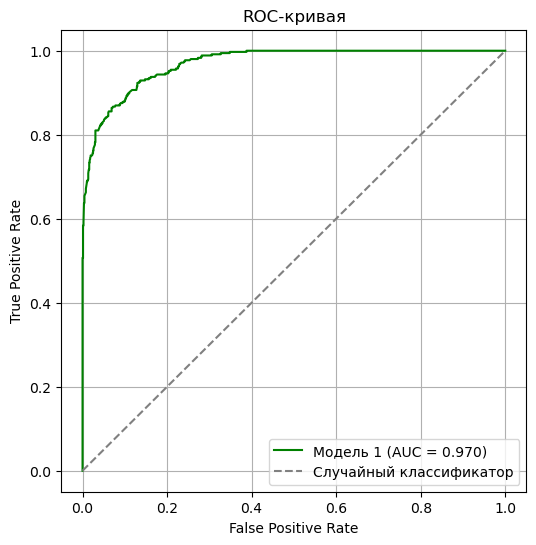

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve


fpr1, tpr1, thresholds = roc_curve(y_test1, y_pred_proba_1[:, 1])

fpr_random = [0, 1]
tpr_random = [0, 1]


plt.figure(figsize=(6,6))
plt.plot(fpr1, tpr1, ls='-', label=f'Модель 1 (AUC = {roc_1:.3f})', color='green')
plt.plot(fpr_random, tpr_random, ls='--', color='grey', label='Случайный классификатор')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend()
plt.grid(True)


2 модель

In [32]:
X2 = df[['numTechTickets', 'calls_count']]
X2 = df[['numTechTickets', 'calls_count', 'tenure']]
Y = df['Churn_encoded']

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, Y,
                                                        test_size=0.2,
                                                        random_state=42)

model2 = LogisticRegression().fit(X_train2, y_train2)


In [33]:
y_pred2 = model2.predict(X_test2)

accuracy_2 = accuracy_score(y_test2, y_pred2)
precision_2 = precision_score(y_test2, y_pred2)
recall_2 = recall_score(y_test2, y_pred2)
f1_2 = f1_score(y_test2, y_pred2)
matrix_2 = confusion_matrix(y_test2, y_pred2)

accuracy_2, precision_2, recall_2, f1_2, matrix_2

(0.8951612903225806,
 0.8105849582172702,
 0.8243626062322946,
 0.8174157303370787,
 array([[819,  68],
        [ 62, 291]]))

In [34]:
y_pred_proba_2 = model2.predict_proba(X_test2)
roc_2 = roc_auc_score(y_test2, y_pred_proba_2[:, 1])
log_2 = log_loss(y_test2, y_pred_proba_2[:, 1])
roc_2, log_2


(np.float64(0.9583709930344191), 0.22900263318369055)

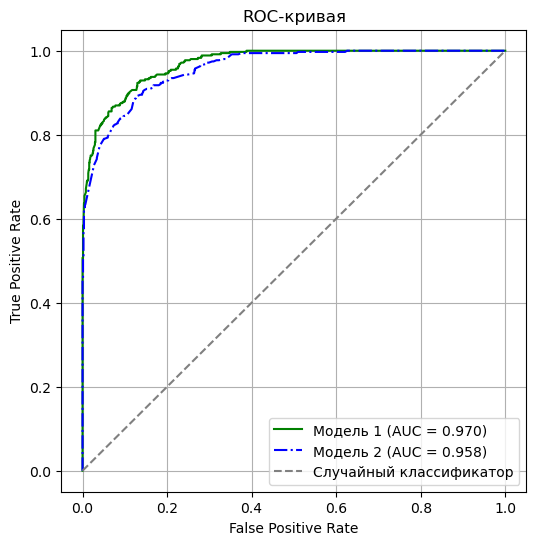

In [35]:
fpr2, tpr2, thresholds2 = roc_curve(y_test2, y_pred_proba_2[:, 1])

fpr_random = [0, 1]
tpr_random = [0, 1]


plt.figure(figsize=(6,6))
plt.plot(fpr1, tpr1, ls='-', label=f'Модель 1 (AUC = {roc_1:.3f})', color='green')
plt.plot(fpr2, tpr2, ls='-.', label=f'Модель 2 (AUC = {roc_2:.3f})', color='blue')
plt.plot(fpr_random, tpr_random, ls='--', color='grey', label='Случайный классификатор')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend()
plt.grid(True)